<a href="https://colab.research.google.com/github/totti0223/deep_learning_for_biologists_with_keras/blob/master/notebooks/rice_seed_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rice Seed Classification

## Preface

How will you classify the bellow two images?

![rice](https://github.com/totti0223/deep_learning_for_biologists_with_keras/raw/master/assets/11.jpg) Proper Shaped Rice Seed

![rice](https://github.com/totti0223/deep_learning_for_biologists_with_keras/raw/master/assets/141.jpg) Broken Rice Seed


## Library and Custom Function Import

In [0]:
import numpy as np 
import math, os, sys

import matplotlib.pyplot as plt

from scipy import ndimage

from skimage import measure, morphology
from skimage.io import imsave, imread
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.transform import resize

from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import pandas as pd

In [0]:
#confusion matrix drawing function provided by sklearn
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [2]:
!apt-get install subversion

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1
Suggested packages:
  db5.3-util libapache2-mod-svn subversion-tools
The following NEW packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1 subversion
0 upgraded, 5 newly installed, 0 to remove and 8 not upgraded.
Need to get 2,237 kB of archives.
After this operation, 9,910 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libapr1 amd64 1.6.3-2 [90.9 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libaprutil1 amd64 1.6.1-2 [84.4 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libserf-1-1 amd64 1.3.9-6 [44.4 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libsvn1 amd64 1.9.7-4ubuntu1 [1,183 kB]
Get:5 http://archive.ubuntu.com/ubuntu bionic/universe amd64 subversion amd64 1.9.7-4ubuntu1 [

## Dataset Import

In [0]:
!svn export https://github.com/totti0223/deep_learning_for_biologists_with_keras/trunk/notebooks/data/image image -q

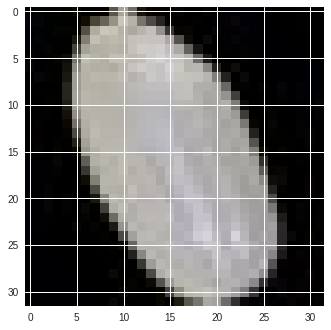

In [4]:
image = imread("image/train/proper/100.jpg")
plt.imshow(image)

In [10]:
#lets load everything into memory

X_train = []
y_train = []

for root, dirs, files in os.walk("image/train"):
    for file in files:
        image_path = os.path.join(root, file)
        
        image = imread(image_path)/255.
        image = resize(image,(32,32))
        X_train.append(image)        
        category = os.path.split(root)[-1]
        if category == "proper":
            y_train.append(0)
        else:
            y_train.append(1)
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = []
y_test = []

for root, dirs, files in os.walk("image/test"):
    for file in files:
        image_path = os.path.join(root, file)
        
        image = imread(image_path)/255.
        image = resize(image,(32,32))
        X_test.append(image)        
        category = os.path.split(root)[-1]
        if category == "proper":
            y_test.append(0)
        else:
            y_test.append(1)
X_test = np.array(X_test)
y_test = np.array(y_test)

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(377, 32, 32, 3) (377,)
(20, 32, 32, 3) (20,)


# 1. Manual Thresholding for Classification

(32, 32, 3)


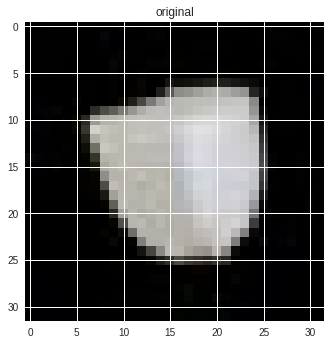

In [20]:
#Let's try it for one image
image = X_train[0]

#the original image
print(image.shape)
plt.imshow(image)
plt.title("original")
plt.show()

(32, 32)


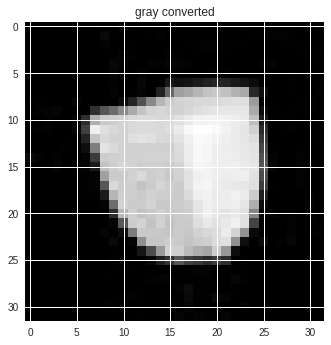

In [21]:
#gray conversion
gray = rgb2gray(image)
print(gray.shape)
plt.imshow(gray, cmap=plt.cm.gray)
plt.title("gray converted")
plt.show()

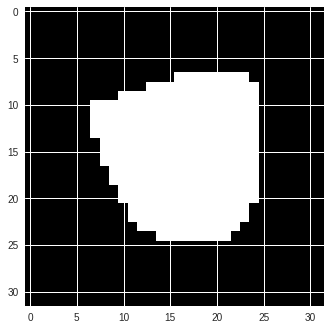

In [22]:
#binary conversion
threshold = threshold_otsu(gray)
binary = gray > threshold
plt.imshow(binary, cmap=plt.cm.gray)
plt.show()

Lets manually define the feature for classification. In this case, simply binarizing the image, extracting the area size of each image and then defining a threshold will do well. All of the image transformation and area measuring can be done with the functions of skimage and scipy.

In [30]:
label_im, nb_labels = ndimage.label(binary)
#検出された領域の特徴（幾何学的性質等）を取得しましょう。
#領域の明度も取得したいので参照用gray画像も併せて利用します。
regionprops = measure.regionprops(label_im, intensity_image=gray)
#複数領域の検出を前提として、regionproprsには結果が複数領域分格納されます。１つ目の領域を指定しましょう。
regionprop = regionprops[0]

#様々な情報を参照できます。
print(regionprop.area)
print(regionprop.major_axis_length)
print(regionprop.minor_axis_length)

265
18.960453228032428
18.350131979990607


In [32]:
#bundling the above into a function
def quantify_area(image):
    gray = rgb2gray(image)
    threshold = threshold_otsu(gray)
    binary = gray > threshold
    label_im, nb_labels = ndimage.label(binary)
    regionprops = measure.regionprops(label_im, intensity_image=gray)
    regionprop = regionprops[0]
    area = regionprop.area
    return area

#test
area = quantify_area(image)
print(area)

265


In [0]:
X_train_area = []
for image in X_train:
    area = quantify_area(image)
    X_train_area.append(area)

X_test_area = []
for image in X_test:
    area = quantify_area(image)
    X_test_area.append(area)

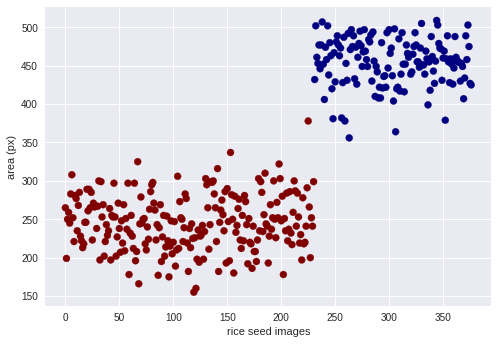

In [59]:
#check the calculated data area value of training dataset
plt.scatter(range(len(X_train_area)),X_train_area,c=y_train,cmap="jet")
plt.xlabel("rice seed images")
plt.ylabel("area (px)")
plt.show()

In [0]:
#define a threshold that can seperate the 

In [0]:
#領域が２つありますので、情報を見てみましょう。
#参考 http://scikit-image.org/docs/0.12.x/api/skimage.measure.html
print (regionprops[0])
print ("面積は", regionprops[0].area,"pxです。")
print ("長軸長は",regionprops[0].major_axis_length,"pxです。")
print ("__________")


面積は 439 pxです。
長軸長は 31.364997117913834 pxです。
__________


In [0]:
#このように標記することもできます。
for region in regionprops:
    print ("面積は", region.area,"pxです。")
    print ("最大明るさは",region.max_intensity,"pxです。")
    print ("平均明るさは",region.mean_intensity,"pxです。")

print ("__________")

#ちなみにwhileを使用した場合。
i = 0
while i < len(regionprops):
    print ("面積は", regionprops[i].area,"pxです。")
    i += 1


面積は 439 pxです。
最大明るさは 0.808110980392 pxです。
平均明るさは 0.623511245701 pxです。
__________
面積は 439 pxです。


In [0]:
#ここまでの処理を関数にまとめてみましょう。
#画像のパスを入れると測定結果を出力してくれる関数です。

def quantify(path_of_image):
    print ("input is", path_of_image)
    image = imread(path_of_image)
    gray = rgb2gray(image)
    threshold = threshold_otsu(gray)
    binary = gray > threshold
    label_im, nb_labels = ndimage.label(binary)
    regionprops = measure.regionprops(label_im, intensity_image=gray)
    for region in regionprops:
        threshold = 50
        if region.area > threshold: #ifを出力するか否かに組み込むことができます。thresholdの値を500にして結果がどうかわるか見てみましょう。
            print ("\t area is", region.area) #\tはタブとして扱われます。windowsの人は¥tでないとただしく反映されない可能性があります。
            print ("\t max intensity is", region.max_intensity)
            print ("\t average intensity is", region.mean_intensity)
        else:
            print ("\t object area bellow the threshold value of", region.area)

quantify("image/train/proper/11.jpg")
quantify("image/train/proper/12.jpg")

input is image/train/proper/11.jpg
	 area is 439
	 max intensity is 0.808110980392
	 average intensity is 0.623511245701
input is image/train/proper/12.jpg
	 area is 498
	 max intensity is 0.836878431373
	 average intensity is 0.639618940074


In [0]:
#image/proper_trainフォルダに入っている画像全てを処理できるようにしましょう。
#フォルダ内のtifを
def get_file_list_in_folder(directory):
    files=[] #空のリストを用意します。
    if os.path.isdir(directory): #もしdirectoryがディレクトリであれば
        for file in os.listdir(directory): #ディレクトリ内のファイルを１つ１つスキャンする
            if file.endswith(".jpg"): #jpgのみ取得する
                files.append(os.path.join(directory,file))  #リストに追加する
        return files
    else:
        print ("not a valid directory!")
        
files = get_file_list_in_folder("image/train/proper")
print (files) #これでproper_trainフォルダ内の写真のパスが得られました。

['image/train/proper/100.jpg', 'image/train/proper/101.jpg', 'image/train/proper/102.jpg', 'image/train/proper/103.jpg', 'image/train/proper/104.jpg', 'image/train/proper/105.jpg', 'image/train/proper/106.jpg', 'image/train/proper/107.jpg', 'image/train/proper/108.jpg', 'image/train/proper/109.jpg', 'image/train/proper/11.jpg', 'image/train/proper/110.jpg', 'image/train/proper/111.jpg', 'image/train/proper/112.jpg', 'image/train/proper/113.jpg', 'image/train/proper/114.jpg', 'image/train/proper/115.jpg', 'image/train/proper/116.jpg', 'image/train/proper/117.jpg', 'image/train/proper/118.jpg', 'image/train/proper/119.jpg', 'image/train/proper/12.jpg', 'image/train/proper/120.jpg', 'image/train/proper/121.jpg', 'image/train/proper/122.jpg', 'image/train/proper/123.jpg', 'image/train/proper/124.jpg', 'image/train/proper/125.jpg', 'image/train/proper/126.jpg', 'image/train/proper/127.jpg', 'image/train/proper/128.jpg', 'image/train/proper/129.jpg', 'image/train/proper/13.jpg', 'image/train

In [0]:
#filesの中身を順番にquantify関数にかけます。
for file in files:
    quantify(file)

input is image/train/proper/100.jpg
	 area is 467
	 max intensity is 0.838374509804
	 average intensity is 0.683414760045
input is image/train/proper/101.jpg
	 area is 475
	 max intensity is 0.91597254902
	 average intensity is 0.729079247059
input is image/train/proper/102.jpg
	 area is 458
	 max intensity is 0.882620784314
	 average intensity is 0.734230063362
input is image/train/proper/103.jpg
	 area is 475
	 max intensity is 0.935007843137
	 average intensity is 0.720269252425
input is image/train/proper/104.jpg
	 area is 443
	 max intensity is 0.915385098039
	 average intensity is 0.73091520648
input is image/train/proper/105.jpg
	 area is 485
	 max intensity is 0.901663137255
	 average intensity is 0.736766806549
input is image/train/proper/106.jpg
	 area is 487
	 max intensity is 0.875596078431
	 average intensity is 0.743889451222
input is image/train/proper/107.jpg
	 area is 488
	 max intensity is 0.899988627451
	 average intensity is 0.740353670845
input is image/train/prope

In [0]:
#このまま結果をコピペして保存してもよいのですが、
#せっかくなのでcsvファイルに書き出せるように関数をいじります。

def quantify_csv(path_of_image):
    print ("input is", path_of_image)
    image = imread(path_of_image)
    gray = rgb2gray(image)
    threshold = threshold_otsu(gray)
    binary = gray > threshold
    label_im, nb_labels = ndimage.label(binary)
    regionprops = measure.regionprops(label_im, intensity_image=gray)
    
    if len(regionprops)==1: #領域が一つだけの場合、測定領域を戻り値として設定する
        return regionprops[0].area,regionprops[0].max_intensity,regionprops[0].major_axis_length,regionprops[0].mean_intensity
    else:
        print ("more than two region detected. ignoring this image file")
        return 0,0,0,0

In [0]:
#csvに書き込むコマンド
csv = open("output.csv", 'a+')#a+は追記モードです。
csv.write("Grain_type,Area,Max_intensity,Major_axis_length,Average_intensity\n") #headerを記入します。
#注意。mac os9より古い人は\r、windowsは\r\n、macosx、linuxは\nに上記文末を変更。
#osによって使用する改行コードが異なるためです。


files = get_file_list_in_folder("image/train/proper")
for file in files:
    area, max_intensity, major_axis_length, mean_intensity = quantify_csv(file)
    if area != 0:#areaが0ではないとき、以下の処理を行う。
        s=",".join(["1",str(area),str(max_intensity),str(major_axis_length),str(mean_intensity)+"\n"])
        #カンマ区切りで連結する。数字と文字は連結できないので、数字を文字変換するstr()
        #改行コードの変更忘れずに
        csv.write(s)

csv.close()

input is image/train/proper/100.jpg
input is image/train/proper/101.jpg
input is image/train/proper/102.jpg
input is image/train/proper/103.jpg
input is image/train/proper/104.jpg
input is image/train/proper/105.jpg
input is image/train/proper/106.jpg
input is image/train/proper/107.jpg
input is image/train/proper/108.jpg
input is image/train/proper/109.jpg
input is image/train/proper/11.jpg
input is image/train/proper/110.jpg
input is image/train/proper/111.jpg
input is image/train/proper/112.jpg
input is image/train/proper/113.jpg
input is image/train/proper/114.jpg
input is image/train/proper/115.jpg
input is image/train/proper/116.jpg
input is image/train/proper/117.jpg
input is image/train/proper/118.jpg
input is image/train/proper/119.jpg
input is image/train/proper/12.jpg
input is image/train/proper/120.jpg
input is image/train/proper/121.jpg
input is image/train/proper/122.jpg
input is image/train/proper/123.jpg
input is image/train/proper/124.jpg
input is image/train/proper/12

In [0]:
#次は割れ米のデータを取る
csv = open("output.csv", 'a+')#a+は追記モードです。

files = get_file_list_in_folder("image/train/broken")
for file in files:
    area, max_intensity, major_axis_length, mean_intensity = quantify_csv(file)
    if area != 0: #areaが0ではないとき、以下の処理を行う。
        #カンマ区切りで連結する。数字と文字は連結できないので、数字を文字変換するstr()
        s=",".join(["2",str(area),str(max_intensity),str(major_axis_length),str(mean_intensity)+"\n"]) #改行コードの変更忘れずに
        csv.write(s)
csv.close()


input is image/train/broken/141.jpg
input is image/train/broken/142.jpg
input is image/train/broken/144.jpg
input is image/train/broken/145.jpg
input is image/train/broken/147.jpg
input is image/train/broken/150.jpg
input is image/train/broken/152.jpg
input is image/train/broken/155.jpg
input is image/train/broken/156.jpg
input is image/train/broken/158.jpg
input is image/train/broken/160.jpg
input is image/train/broken/161.jpg
input is image/train/broken/162.jpg
input is image/train/broken/164.jpg
input is image/train/broken/165.jpg
input is image/train/broken/166.jpg
input is image/train/broken/167.jpg
input is image/train/broken/168.jpg
input is image/train/broken/169.jpg
input is image/train/broken/170.jpg
input is image/train/broken/171.jpg
input is image/train/broken/172.jpg
input is image/train/broken/173.jpg
input is image/train/broken/174.jpg
input is image/train/broken/175.jpg
input is image/train/broken/176.jpg
input is image/train/broken/177.jpg
input is image/train/broken/

In [0]:
#完成したoutput.csvファイルを開いて確認してみてください。
#このままエクセルやRで解析しても構いません。
#ここまでで大量の画像から任意の情報を取得する方法を紹介しました。

In [0]:
#整粒米と割れ米を識別するレベル１人工知能を作ってみましょう。

In [0]:
#先程作成したcsvファイルを読み込む
df =pd.read_csv("output.csv") #データフレームとして読み込みます。 #ここまでの処理がうまくいかなかった人はoutput_sample.csvを使用してください。
#df =pd.read_csv("output_sample.csv") 

x = df[["Area","Major_axis_length"]] #xに二列分のデータを読み込みます。
X = x.as_matrix() #配列に変換しています。
y = df["Grain_type"] #区分を読み込みます。
y = y.as_matrix()

print ("読み込まれました")

読み込まれました


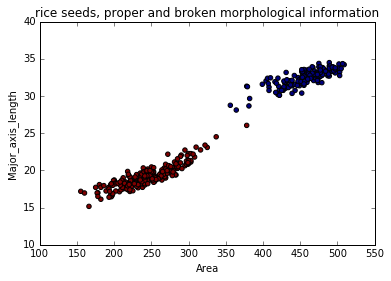

In [0]:
#面積をx軸、平均輝度をy軸にプロットした図を作成してみましょう。

#散布図を作成します。x,y,色ラベル情報,カラーマップと並びます。
plt.scatter(X[:, 0], X[:, 1], c=y)
#軸情報
plt.xlabel('Area')
plt.ylabel('Major_axis_length')
plt.title('rice seeds, proper and broken morphological information')
plt.show()

#エラーがでる場合はoutput.csvを削除してIn[46]からやりなおしてください。

In [0]:
#どうやら面積と長軸長さどちらでも分類ができそうです。今回は面積にしましょう。
#面積を”特徴”に正粒米と割れ米を識別する装置をつくります。

#設計プロセス
#フォルダの中にあるファイルの数を数える
#画像一枚ずつ面積を測る。
#閾値より大きければ整粒米、閾値より小さければ割れ米として処理をする。


#画像のパスと閾値を入力すると、整粒米であれば１、割れ米であれば２、測定できなかった場合３を返す関数
def classify(path_of_image,area_threshold): 
    image = imread(path_of_image)
    gray = rgb2gray(image)
    threshold = threshold_otsu(gray)
    binary = gray > threshold
    label_im, nb_labels = ndimage.label(binary)
    regionprops = measure.regionprops(label_im, intensity_image=gray)
    if len(regionprops)==1: #今回は領域が一つだけ測定できた場合のみにかぎりましょう。
        if regionprops[0].area > area_threshold:
            return 1
        else:
            return 2
    else:
        return 3
    
#ファイルのリストを引数としてとり、整粒米、割れ米、測定できなかった数を集計して返す関数
def count(files,area_threshold):
    no_of_proper = 0
    no_of_broken = 0
    no_of_error = 0

    for file in files:
        result = classify(file,area_threshold) #判別する
        if result == 1:
            no_of_proper += 1
        if result == 2:
            no_of_broken += 1
        if result == 3:
            no_of_error += 1
    return no_of_proper, no_of_broken, no_of_error

In [0]:
files = get_file_list_in_folder("image/train/proper") #上の方で定義したファイルリストを取得する関数
files2 = get_file_list_in_folder("image/train/broken")
#count関数を実行すると、一つ一つの画像に対してclassify関数を実行し、整粒米か割れ米か区別し、帰ってきた結果を集計します。

area_threshold = 30

no_of_proper, no_of_broken, no_of_error = count(files,area_threshold)
length = len(files)
print ("整粒米ディレクトリに入っている画像は",length,"枚です")
print ("測定できたのは",no_of_proper+no_of_broken,"枚です。")
print ("整粒米と判定されたのは",no_of_proper,"枚です。")
print ("割れ米と判定されたのは",no_of_broken,"枚です。")
print ("_________________________________________")
no_of_proper, no_of_broken, no_of_error = count(files2,area_threshold)
length = len(files2)
print ("割れ米ディレクトリに入っている画像は",length,"枚です")
print ("測定できたのは",no_of_proper+no_of_broken,"枚です。")
print ("整粒米と判定されたのは",no_of_proper,"枚です。")
print ("割れ米と判定されたのは",no_of_broken,"枚です。")

#area_thresholdの値を変えながら誤分類がなるべくすくなくなるような値を探してみましょう。
#散布図を見れば想像がつきますが、大体350あたりがよさそうですね。

整粒米ディレクトリに入っている画像は 146 枚です
測定できたのは 146 枚です。
整粒米と判定されたのは 146 枚です。
割れ米と判定されたのは 0 枚です。
_________________________________________
割れ米ディレクトリに入っている画像は 231 枚です
測定できたのは 231 枚です。
整粒米と判定されたのは 231 枚です。
割れ米と判定されたのは 0 枚です。


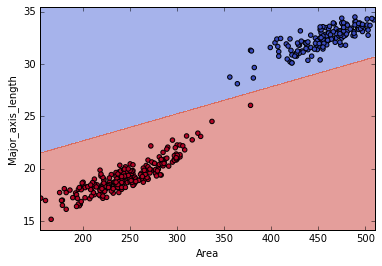

In [0]:
#閾値を手で設定するのは少々大変です。
#レベル２人工知能をつかって閾値を自動的に計算してもらいましょう。
#今回はサポートベクターマシーン（機械学習の一種）による計算を行います。

#念の為読み込みなおす。
#---------------------------
df =pd.read_csv("output.csv")

x = df[["Area","Major_axis_length"]] #xに二列分のデータを読み込みます。
X = x.as_matrix() #配列に変換しています。
y = df["Grain_type"] #区分を読み込みます。
y = y.as_matrix()
#---------------------------

C = 1.0  # SVM regularization parameter
svc=svm.SVC(kernel='linear',C=C).fit(X,y)

h = .02  # step size in the mesh
# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors

# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.5)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
plt.xlabel('Area')
plt.ylabel('Major_axis_length')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.show()


#結果はどのように表示されましたか？
#レベル１では面積のみを指標にしましたが、サポートベクターマシーンは面積と長軸長双方とも使用しているようですね。

In [0]:
#作成した分類器はこのように使うことができます。
virtual_rice = [400,35]  #面積、長軸長
value = np.array(virtual_rice).reshape(1,-1)
prediction = svc.predict(value)
print ("入力された情報から推測される分類クラスは",prediction,"です")
#１が整粒米、２が割れ米です。
#virtual_riceの情報を色々変えてみて結果がどうかわるか試してみて下さい。

入力された情報から推測される分類クラスは [1] です


In [0]:
#おまけ。分類器の保存と復元
#保存したファイルを取っておいて、他のプログラムと組み合わせる事ができます。
#http://web-salad.hateblo.jp/entry/2014/11/09/090000
joblib.dump(svc,'svm_checkpoint.pkl') #保存します
svc=joblib.load('svm_checkpoint.pkl') #復元します
print (svc.predict(value)) #使います。

[1]


In [0]:
#ちなみに他のパラメーターを使用するとどうなるでしょうか？
#整流米は割れ米に比べて楕円らしさが高いですね。
#regionspropsに楕円らしさを測るeccentricityがあります(1が完全な楕円)。それを使用してみましょう。
#csvに保存せずに変数の受け渡しのみで最後までいってみましょう。

proper_ec = [] #空のリストを作成します
broken_ec = []

proper_seeds = get_file_list_in_folder("image/train/proper")  #前に定義した関数を使いまわします。
broken_seeds = get_file_list_in_folder("image/train/broken")

for path_of_image in proper_seeds:
    image = imread(path_of_image)
    gray = rgb2gray(image)
    threshold = threshold_otsu(gray)
    binary = gray > threshold
    label_im, nb_labels = ndimage.label(binary)
    regionprops = measure.regionprops(label_im, intensity_image=gray)
    if len(regionprops) == 1: #1個のみ領域が検出された場合、以下の処理を行う。
        a = regionprops[0].eccentricity
        proper_ec.append(a) #楕円度

for path_of_image in broken_seeds:
    image = imread(path_of_image)
    gray = rgb2gray(image)
    threshold = threshold_otsu(gray)
    binary = gray > threshold
    label_im, nb_labels = ndimage.label(binary)
    regionprops = measure.regionprops(label_im, intensity_image=gray)
    if len(regionprops) == 1: #1個のみ領域が検出された場合、以下の処理を行う。
        a = regionprops[0].eccentricity
        broken_ec.append(a) #楕円度


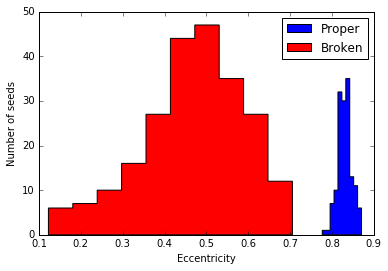

In [0]:
plt.hist(proper_ec,bins=10,histtype='stepfilled', color='b', label='Proper')
plt.hist(broken_ec,bins=10,histtype='stepfilled', color='r', label='Broken')
plt.legend()
plt.xlabel("Eccentricity")
plt.ylabel("Number of seeds")
plt.show()

#このような尺度（特徴量）でも分類することができそうですね。
#このように特徴量設計（定義）がうまくいけば高精度で解析が可能です。ただ、生物情報の解析は往々にして
#うまくいきません、そのような時はレベル３人工知能で紹介するディープラーニングが強い力を発揮します。
#ディープラーニングを利用すると、特徴量設計をコンピュータにまかせることができます。

In [0]:
#次はディープラーニング、レベル３人工知能

In [0]:
from __future__ import print_function
import keras
#from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

In [0]:
#ディレクトリから画像を読み込みます。

train_datagen = ImageDataGenerator( #data augmentation　訓練データを水増しします。
        rescale=1./255,
        horizontal_flip=True,
        vertical_flip=True)

test_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        vertical_flip=True)

train_generator = train_datagen.flow_from_directory(
        'image/train/',
        target_size=(32, 32), #height,widthのサイズに強制リサイズします。
        batch_size=32,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        'image/valid/',
        target_size=(32, 32),
        batch_size=32,
        class_mode='categorical')

print (train_generator.class_indices)
print (validation_generator.class_indices)
#one hot encoding.　正常　＝ [0,1]　割れ= [1,0]といったラベルになっています

Found 377 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
{'proper': 1, 'broken': 0}
{'proper': 1, 'broken': 0}


In [0]:
#モデルの定義。cifar-10のサンプルを流用しています。


input_shape = (32,32,3)

model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same',input_shape=input_shape))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('softmax'))

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [0]:
#モデルをチェックしてみましょう。
model.summary()

In [0]:
model.fit_generator(
        train_generator,
        samples_per_epoch=1000,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=10)

model.save("model.hdf5")

In [0]:
#model.load_weights("model.hdf5")で読み込むことができます。このnotebookを閉じない限りmodelは読み込まれたままです。
from skimage.transform import resize

inputdata = imread("image/146.jpg")/255.
inputdata = resize(inputdata,(32,32))
inputdata = np.expand_dims(inputdata,axis=0)
print(inputdata.shape)

#(1, 32, 32, 3)　（バッチ、height, width, channel）
#モデルには複数の画像（バッチ）を入力するようにしているので、単一のバッチと定義するため、expand_dimを使用
#カラーなので、最後の3はRGBで3チャネルです。

y = model.predict(inputdata)
#0~1の結果が返ってくるので１００をかけて０〜１００％表示に修正
print(y*100.0)

#[0,1]で100%正常米
#[1,0]で100%割れ米


result = np.argmax(y) #何番目の数値が大きいか
if result == 0:
    print ("この画像は割れ米の可能性",y[0][0]*100,"%です")

if result == 1:
    print ("この画像は正常米の可能性",y[0][1]*100,"%です")



(1, 32, 32, 3)
[[  9.99642715e+01   3.57273631e-02]]
この画像は割れ米の可能性 99.9642729759 %です


In [0]:
#第１層のフィルタの可視化や
#フィルタ適用後の画像等を表示すると、ネットワークがどのように学習しているかより深い理解が可能になります。
#インターネットの様々なサイトでコードを参照できるので各自調べてみて下さい。

#今日はここまでです。